In [3]:
import sys
#sys.path
sys.path.append('../')

In [4]:
%load_ext autoreload
%autoreload 2
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data
import exponential_modeling
import fit_and_predict
import copy

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## get prediction for next day

There are currently two models:   
  1. method="exponential" fits an exponential curve to the number of deaths  
  2. method="cases_exponential_rate_constant" fits an exponential curve to the number of cases, and use the death rate of the previous day to estimate deaths  

In [5]:
df = load_data.load_county_level(data_dir = '../data/')
outcome_deaths = '#Deaths_3/30/2020'
df = df.sort_values(outcome_deaths, ascending=False)
#outcome_cases = load_data.outcome_cases # most recent day
#outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)

In [278]:
df.keys()

Index(['id', 'Header-FIPSStandCtyCode', 'EntityofFile',
       'SecondaryEntityOfFile', 'DateofFile', 'DateofCreation', 'FileLength',
       'StateName', 'StateNameAbbreviation', 'CountyName',
       ...
       '#Deaths_3/22/2020', '#Deaths_3/23/2020', '#Deaths_3/24/2020',
       '#Deaths_3/25/2020', '#Deaths_3/26/2020', '#Deaths_3/27/2020', 'deaths',
       'cases', 'tot_deaths', 'tot_cases'],
      dtype='object', length=7318)

In [283]:
df = exponential_modeling.estimate_deaths(df, mode='predict_future')

In [287]:
df['deaths'].values[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  21,  40,  60,  92, 124,
       149])

In [284]:
df['predicted_deaths_exponential']

1841    [231.98702647965587]
2941    [141.89562378110494]
1824    [155.85977461115073]
1803     [151.5894789479785]
1831      [124.153507351064]
                ...         
1107                     [0]
1108                     [0]
1110                     [0]
1112                     [0]
3113                     [0]
Name: predicted_deaths_exponential, Length: 3114, dtype: object

## Validation (for counties with more than 5 deaths)

In [221]:
df2 = exponential_modeling.create_leave_one_day_out_valid(df)
method = 'cases_exponential_rate_constant'
df2 = exponential_modeling.estimate_deaths(df2, method=method)

In [222]:
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
preds = np.array([df2['predicted_deaths_exponential'].values[i][0] for i in range(len(df))])

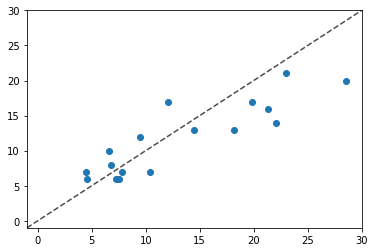

In [223]:
plt.scatter((preds[outcome > 5]), (outcome[outcome > 5]))
axis_lim = [-1, 30]
plt.xlim(axis_lim)
plt.ylim(axis_lim)
plt.plot(axis_lim, axis_lim, ls="--", c=".3")

## Different time horizon

In [224]:
h = 3 # predicting 3 days in advance
previous_deaths = [d[:-h] for d in copy.deepcopy(df['deaths'])]
previous_cases = [c[:-h] for c in copy.deepcopy(df['cases'])]
train_df = copy.deepcopy(df)
train_df['deaths'] = previous_deaths
train_df['cases'] = previous_cases
#test_df = copy.deepcopy(df)
#df_preds = fit_and_predict.fit_and_predict(train_df, test_df, method='exponential', target_day=[h])

### fitting exponential curve to number of deaths

In [225]:
#df_preds = fit_and_predict.fit_and_predict(train_df, test_df, method='exponential', target_day=[h])
df_preds = exponential_modeling.estimate_deaths(train_df,
                                                method='exponential',
                                                target_day=np.array([h]))
preds = [df_preds['predicted_deaths_exponential'].values[i][0] for i in range(len(df))]

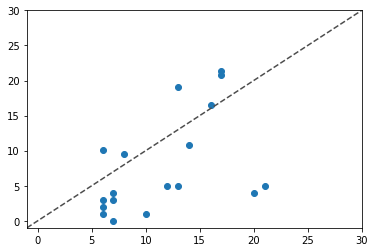

In [226]:
plt.scatter((outcome[outcome > 5]), np.array(preds)[outcome > 5])
axis_lim = [-1, 30]
plt.xlim(axis_lim)
plt.ylim(axis_lim)
plt.plot(axis_lim, axis_lim, ls="--", c=".3")

## underestimaing most of the time

### fitting exponential curve to number of cases, then multiply by death rate

In [227]:
method = 'cases_exponential_rate_constant'
df_preds = exponential_modeling.estimate_deaths(train_df,
                                                method=method,
                                                target_day=np.array([h]))
preds = [df_preds['predicted_deaths_exponential'].values[i][0] for i in range(len(df))]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])

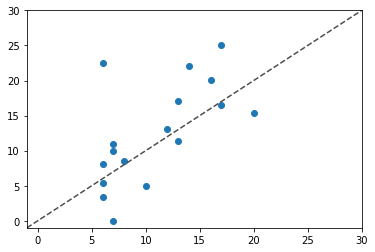

In [230]:
plt.scatter((outcome[outcome > 5]), np.array(preds)[outcome > 5])
axis_lim = [-1, 30]
plt.xlim(axis_lim)
plt.ylim(axis_lim)
plt.plot(axis_lim, axis_lim, ls="--", c=".3")

## overestimaing most of the time

In [288]:
df = fit_and_predict.get_forecasts(df,
                                   outcome='deaths',
                                   method='exponential',
                                   output_key='predicted_deaths_exponential')

In [291]:
df = fit_and_predict.get_forecasts(df,
                                  outcome='deaths',
                                  method='shared_exponential',
                                  output_key='predicted_deaths_shared_exponential')

In [308]:
[df['predicted_deaths_shared_exponential'].values[i] * 0.5 for i in range(len(df))]

[array([91.83140569]),
 array([60.5753326]),
 array([64.1128878]),
 array([63.08659623]),
 array([46.28457438]),
 array([28.36170459]),
 array([17.91190475]),
 array([17.74773649]),
 array([17.10008904]),
 array([16.95756747]),
 array([15.14772518]),
 array([12.52533257]),
 array([9.8067413]),
 array([11.46101449]),
 array([13.09581243]),
 array([14.26114725]),
 array([9.65783486]),
 array([12.34755936]),
 array([7.07541064]),
 array([9.12181775]),
 array([5.87533265]),
 array([6.01784722]),
 array([5.17241926]),
 array([4.65141422]),
 array([4.24278895]),
 array([4.31644242]),
 array([3.29655439]),
 array([4.76743847]),
 array([4.67611527]),
 array([6.73922249]),
 array([3.89723011]),
 array([3.59115977]),
 array([4.06459409]),
 array([4.91924811]),
 array([3.85548034]),
 array([5.05851893]),
 array([3.666669]),
 array([2.93686481]),
 array([3.51817602]),
 array([3.75221173]),
 array([5.98841137]),
 array([3.05244311]),
 array([3.57719144]),
 array([5.3122563]),
 array([2.75092981]),


In [ ]:
### weighted estimators

In [302]:
import pmdl_weight
weights = pmdl_weight.compute_pmdl_weight(df, methods=['shared_exponential', 'exponential'], outcome='deaths')

In [305]:
weights['exponential'][:20]

array([7.24353195e-11, 2.12213924e-06, 7.23551909e-12, 5.47678197e-14,
       7.70503754e-10, 5.30437892e-02, 4.75048392e-02, 7.43205330e-04,
       3.07095976e-02, 5.13139513e-02, 4.19464783e-02, 4.81135213e-02,
       4.31871028e-02, 9.52193547e-02, 1.67834725e-01, 1.14920117e-01,
       2.37880822e-01, 4.89238067e-02, 1.65827832e-01, 6.40143831e-02])

In [306]:
weights['shared_exponential'][:20]

array([3.19371114e-09, 5.28037080e-07, 1.73327588e-07, 2.87738922e-09,
       6.50862040e-11, 2.24014384e-03, 1.23853499e-03, 9.12932404e-04,
       2.98471854e-02, 5.10919528e-02, 5.84752408e-02, 6.04218184e-02,
       3.96575726e-03, 5.43044861e-02, 9.42122826e-02, 2.53236004e-02,
       1.90427374e-01, 2.10005929e-02, 1.75759236e-01, 3.72785398e-01])

In [ ]:
df = load_data.load_county_level(data_dir = '../data/')
outcome_deaths = '#Deaths_3/30/2020'
df = df.sort_values(outcome_deaths, ascending=False)
#outcome_cases = load_data.outcome_cases # most recent day
#outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)

In [7]:
import fit_and_predict_ensemble

In [9]:
very_important_vars = ['PopulationDensityperSqMile2010',
#                        'MedicareEnrollment,AgedTot2017',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals']
exponential = {'model_type':'exponential'}
shared_exponential = {'model_type':'shared_exponential'}
demographics = {'model_type':'shared_exponential', 'demographic_vars':very_important_vars}

In [40]:
df = fit_and_predict_ensemble.fit_and_predict_ensemble(df, 
                                                       target_day=np.array([3]),
                                                       mode='eval_mode',
                                                       methods=[exponential, 
                                                                shared_exponential,
                                                                demographics],
                                                       output_key='ensemble_test'
                                                       )

Feature weights
log(deaths) : 0.9590919556921857
bias : 0.31677956323982803
Feature weights
PopulationDensityperSqMile2010 : 9.147608738492015e-06
PopulationEstimate2018 : -4.174863702969321e-09
#ICU_beds : -0.0005522016792419315
MedianAge2010 : 0.04095352692425887
Smokers_Percentage : -0.013982610511818736
DiabetesPercentage : 0.05434426606715878
HeartDiseaseMortality : 0.0011030630384219462
#Hospitals : 0.019093342485364675
log(deaths) : 0.9027709570694145
bias : -1.580885527986501
Feature weights
log(deaths) : 0.9480053801478276
bias : 0.34732083592365026
Feature weights
log(deaths) : 0.9214259382229086
bias : 0.4285852132144907
Feature weights
log(deaths) : 0.9028129100105916
bias : 0.4658043303363327
Feature weights
log(deaths) : 0.8680259332262948
bias : 0.5513308367025739
Feature weights
log(deaths) : 0.8353455058469212
bias : 0.6242549547760792
Feature weights
log(deaths) : 0.9786054501591184
bias : 0.15295309287728487
Feature weights
log(deaths) : 0.9778959946505013
bias : 0.1

In [41]:
df['ensemble_test']

1841    292.888230
1824    198.731778
1803    192.003811
2941    152.140288
1831    121.479693
           ...    
1149      5.753645
1150      2.975200
1151      3.925126
1153      2.922314
3113      2.722787
Name: ensemble_test, Length: 3114, dtype: float64

In [42]:
[df['deaths'].values[i][-1] for i in range(len(df))]

[305.0,
 216.0,
 215.0,
 150.0,
 119.0,
 86.0,
 83.0,
 58.0,
 48.0,
 48.0,
 44.0,
 44.0,
 44.0,
 37.0,
 32.0,
 31.0,
 28.0,
 27.0,
 21.0,
 20.0,
 19.0,
 18.0,
 18.0,
 16.0,
 15.0,
 14.0,
 12.0,
 12.0,
 12.0,
 11.0,
 11.0,
 11.0,
 11.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 9.0,
 9.0,
 9.0,
 9.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.

In [43]:
lower_threshold = 20
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in ['ensemble_test']:
    preds = [p for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds))

Raw l1 for ensemble_test
13.358945884201235


In [26]:
def l1(arr1,arr2):
    return sum([np.abs(a1-a2) for (a1,a2) in zip(arr1,arr2)])/len(arr1)